# COGS 118A - Final Project

# Income Classification: Over or Under 50k

# Names
- Galen Ng
- Regan Yang
- Andy Chen

# Abstract 
The goal of this project is to identify whether a person with specific metrics will make more or less than $50,000 a year. The data used will be a kaggle dataset showing features that contribute to an individual's income. This would include features such as gender, race, occupation, and all the information would have to classify the individual. There are certain features that don't have numerical values such as race or occupation so we can one hot encode those features. With this data, we will perform some exploratory data analysis on these features and see if there are biases that we can exclude such as a feature that measures higher education which already is statistically known to be heavily correlated with income. The reason why we would do this is to determine what other not so well known features would attribute to classifying income. Once all of that is done, we will use our clean dataset to classify people who make more or less than 50,000 annually. Performance of a model is measured by accuracy and f1-score.

# Background

According to the United States government <a name="incomeImportance"></a>[<sup>[1]</sup>](#importance-income), accurate survey data about income is hard to come by. There's plenty of issues in reporting data such as difficulty in understanding income questions, different interpretations of income questions, and other factors that make income reporting not as reliable as one might think. Having accurate income data is important as income data is an important metric in determining health related quality of life<a name="incomeHealth"></a>[<sup>[2]</sup>](#health-income). The idea of success to a lot of people is through financial accomplishments and one of the most important things for people to value themselves is by how much they make annually. Furthermore, a person reaches about $50k, they can be classified as middle class.<a name="midIncome"></a>[<sup>[3]</sup>](#mid-income).

# Problem Statement
Given a set of initial circumstances (age, workclass, education, marital status, occupation, relationship, race, sex, capital gain/loss, native country), does a person make at least or less than $50k a year? To answer such a question, we can develop a ML model takes in the circumstances as input and produce a binary classification based on the data. To make sure our results are replicable by clearly documenting our steps. To make the problem measurable, we decided to use accuracy and F1-score as performance metrics. Accuracy tells us how the ratio of correct predictions over total predictions. In case the data is imbalanced, we use F1-score to get a more balanced result.

# Imports

In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

warnings.filterwarnings('ignore')

# Data
Dataset: https://www.kaggle.com/datasets/lodetomasi1995/income-classification

In [55]:
data = pd.read_csv("income_evaluation.csv")
data.shape
# 32,561 observations, 15 variables

(32561, 15)

In [56]:
data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [57]:
# Check for null entries
data.isnull().sum()

age                0
 workclass         0
 fnlwgt            0
 education         0
 education-num     0
 marital-status    0
 occupation        0
 relationship      0
 race              0
 sex               0
 capital-gain      0
 capital-loss      0
 hours-per-week    0
 native-country    0
 income            0
dtype: int64

# Data Cleaning + EDA

In [58]:
data = pd.read_csv("income_evaluation.csv")
# For some reason some column names have a space at the start
data = data.rename(str.strip, axis='columns')
data = data.drop('education-num', axis='columns')
# Done for classification purposes
data['income'] = data['income'].replace([' <=50K', ' >50K'], [0, 1])
data.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [59]:
X = data.drop('income', axis='columns')
y = data['income']

In [60]:
num_cols = ['age', 'fnlwgt', 'hours-per-week']
cat_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

In [70]:
data['income'].value_counts()

0    24720
1     7841
Name: income, dtype: int64

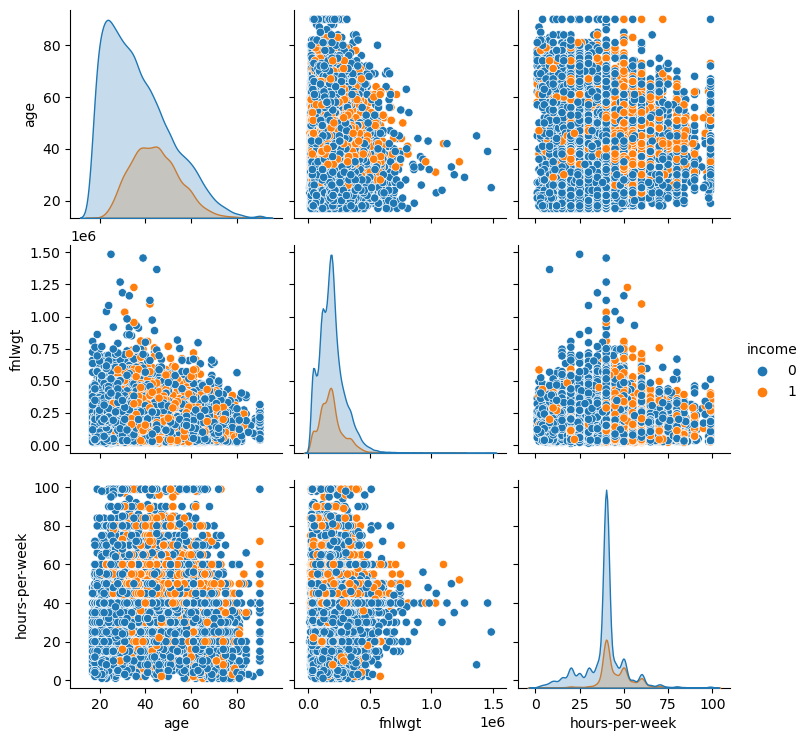

In [73]:
numerics = data[num_cols]
numerics['income'] = data['income']
sns.pairplot(numerics, hue='income')

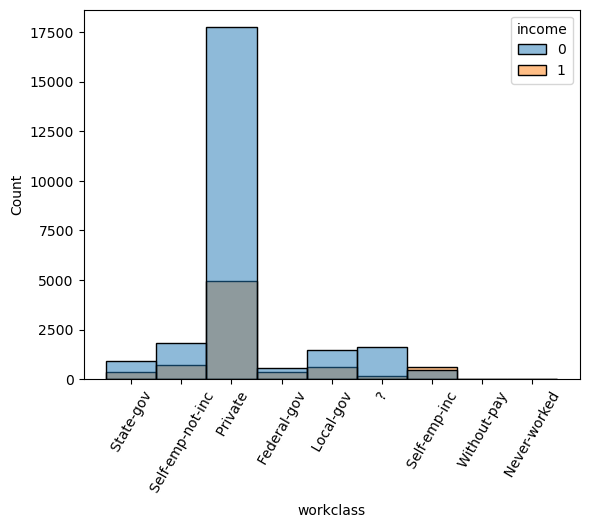

In [62]:
p1 = sns.histplot(data=data, x='workclass', hue='income')
plt.xticks(rotation=60)
plt.show()

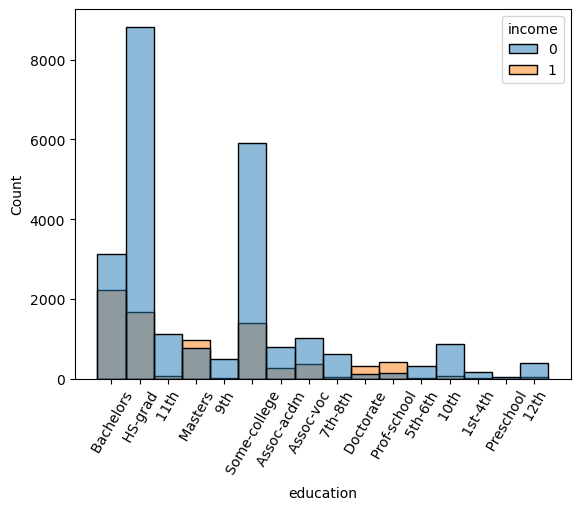

In [63]:
p2 = sns.histplot(data=data, x='education', hue='income')
plt.xticks(rotation=60)
plt.show()

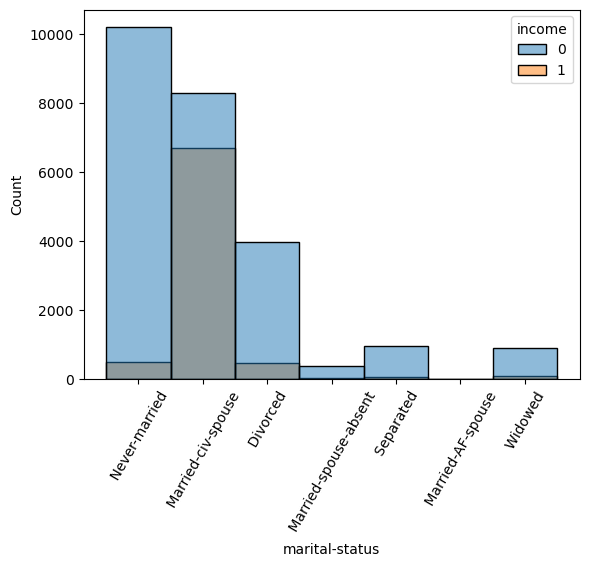

In [64]:
p3 = sns.histplot(data=data, x='marital-status', hue='income')
plt.xticks(rotation=60)
plt.show()

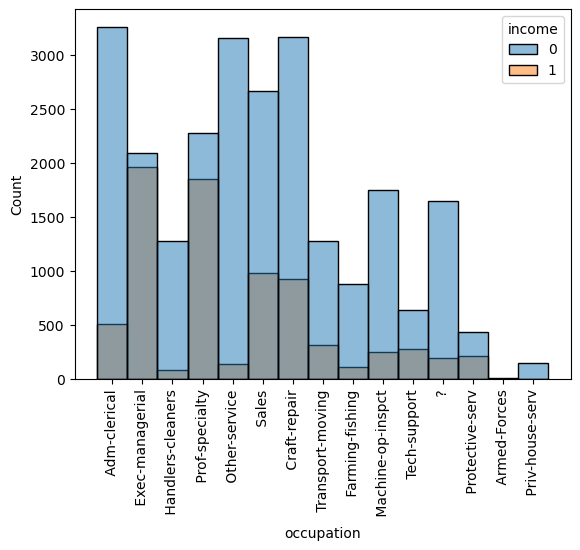

In [71]:
p4 = sns.histplot(data=data, x='occupation', hue='income')
plt.xticks(rotation=90)
plt.show()

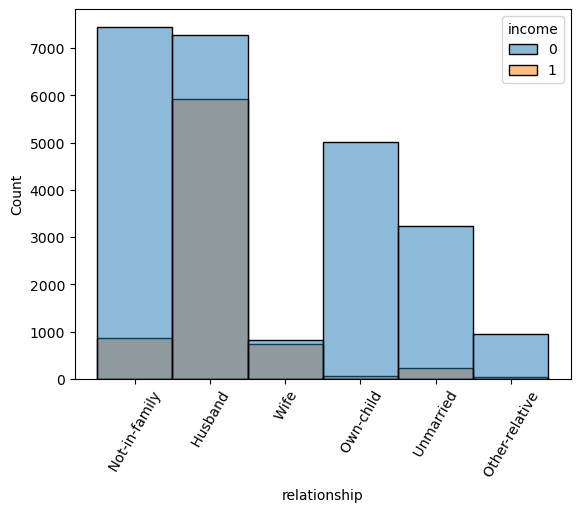

In [66]:
p5 = sns.histplot(data=data, x='relationship', hue='income')
plt.xticks(rotation=60)
plt.show()

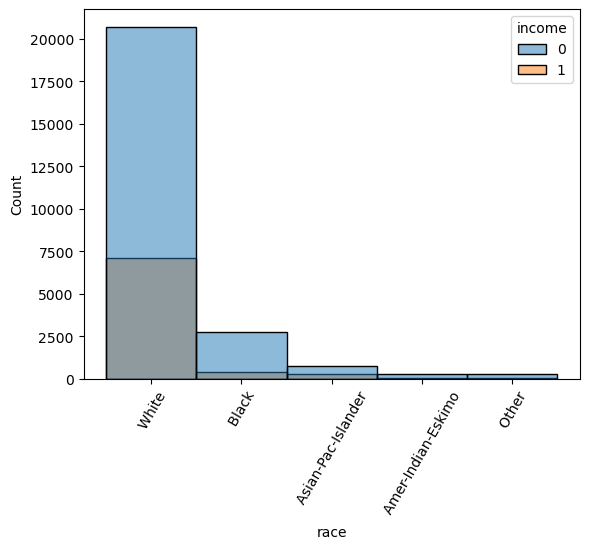

In [67]:
p6 = sns.histplot(data=data, x='race', hue='income')
plt.xticks(rotation=60)
plt.show()

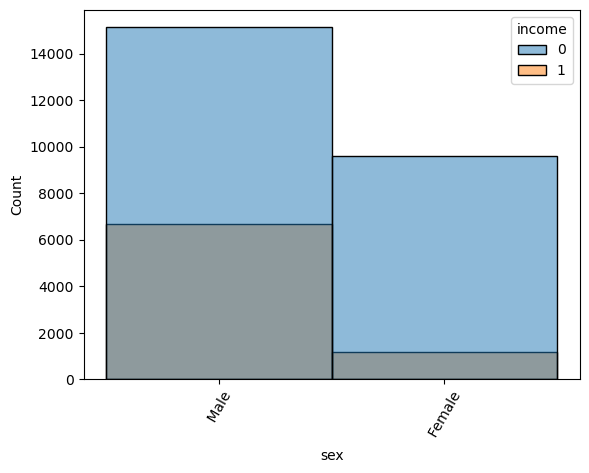

In [68]:
p7 = sns.histplot(data=data, x='sex', hue='income')
plt.xticks(rotation=60)
plt.show()

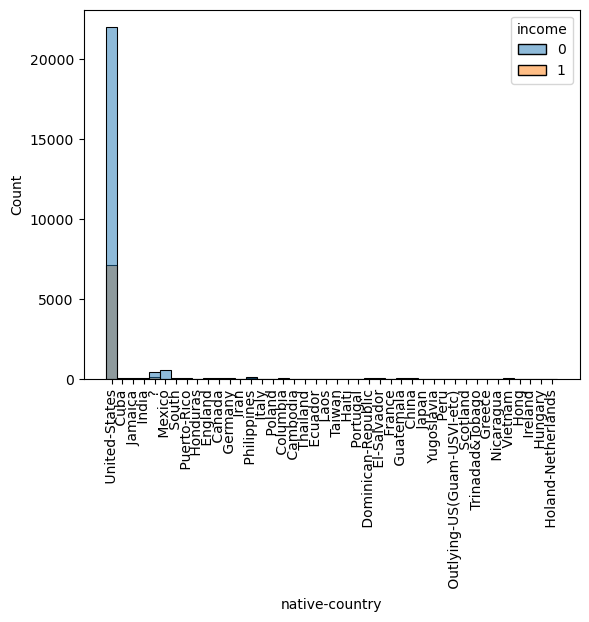

In [69]:
p8 = sns.histplot(data=data, x='native-country', hue='income')
plt.xticks(rotation=90)
plt.show()

For most of the variables, the <=\\$50k and >\\$50k follow the same kinds of patterns. For education, there is a clear tendency for higher education levels in the >\\$50k group. For occupation, both groups have different distributions, but two of the top 4 occupations (sales, craft-repair) for both groups are the same. For relationship, it seems the >\\$50k group has a tendency for being in a marriage.

# Proposed Solution

Since we are trying to classify whether a participant has an income >= 50k or < 50k, we can use a logistic regression or SVM classifier using different regularization strengths. Both classifiers give the probabilities of data points belonging to a binary classification. A solution can be tested by using train-test splits and comparing it to other test sets. We chose logistic regression because it provides probability based outcomes and is a computationally simple algorithm that is robust to noise. Similarly, SVM can avoid overfitting via regularization and can help the model deal with issues that arises from dealing with higher dimensional data.

# Evaluation Metrics

One evaluation metric we can use is accuracy. As we are making binary decisions, we want to know if our model is making the correct decisions for the data points it's given. We can set up a good k-folds cross validation to reduce bias in the data and also look at the f1 score to measure the accuracy and quantify it. With our k-folds cross validation, we can split up the data into k-folds which allows the model to be more versatile when it comes to newer data and also reduces bias in the model. K-folds cross validation is our primary method of reducing overfitting by having multiple models trained on different portions of the data.

# Logistic Regression

In [9]:
pipe = Pipeline([('make_features', preprocessor),
                 ('classifier', LogisticRegression(solver='saga', max_iter=10000))])

search_space = {'classifier__C': np.logspace(-3, 3, 7),
               'classifier__penalty': ['l2', 'l1']}

best_model = GridSearchCV(pipe, search_space, cv=5, verbose=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, random_state=101)

best_model.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END classifier__C=0.001, classifier__penalty=l2;, score=0.802 total time=   1.0s
[CV 2/5] END classifier__C=0.001, classifier__penalty=l2;, score=0.791 total time=   1.1s
[CV 3/5] END classifier__C=0.001, classifier__penalty=l2;, score=0.799 total time=   1.1s
[CV 4/5] END classifier__C=0.001, classifier__penalty=l2;, score=0.799 total time=   1.1s
[CV 5/5] END classifier__C=0.001, classifier__penalty=l2;, score=0.798 total time=   0.9s
[CV 1/5] END classifier__C=0.001, classifier__penalty=l1;, score=0.756 total time=   0.8s
[CV 2/5] END classifier__C=0.001, classifier__penalty=l1;, score=0.756 total time=   0.8s
[CV 3/5] END classifier__C=0.001, classifier__penalty=l1;, score=0.759 total time=   0.8s
[CV 4/5] END classifier__C=0.001, classifier__penalty=l1;, score=0.758 total time=   0.7s
[CV 5/5] END classifier__C=0.001, classifier__penalty=l1;, score=0.758 total time=   0.7s
[CV 1/5] END classifier__C=0.01, classi

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('make_features',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'fnlwgt',
                                                                          'hours-per-week']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['workclass',
                                                                          'education',
                                                                          'marital-status',
                                   

# SVM

In [10]:
pipe2 = Pipeline([('make_features', preprocessor),
                 ('classifier', SVC())])
search_space2 = {'classifier__kernel': ['linear'],
                 'classifier__C': np.logspace(-3, 1, 5)
                }

best_model2 = GridSearchCV(pipe2, search_space2, cv=5, verbose=3)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, 
                                                    test_size=0.25, random_state=101)

best_model2.fit(X_train2, y_train2)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END classifier__C=0.001, classifier__kernel=linear;, score=0.783 total time=   9.9s
[CV 2/5] END classifier__C=0.001, classifier__kernel=linear;, score=0.788 total time=  10.2s
[CV 3/5] END classifier__C=0.001, classifier__kernel=linear;, score=0.779 total time=   9.9s
[CV 4/5] END classifier__C=0.001, classifier__kernel=linear;, score=0.782 total time=   9.7s
[CV 5/5] END classifier__C=0.001, classifier__kernel=linear;, score=0.783 total time=   9.9s
[CV 1/5] END classifier__C=0.01, classifier__kernel=linear;, score=0.830 total time=   8.7s
[CV 2/5] END classifier__C=0.01, classifier__kernel=linear;, score=0.821 total time=   8.8s
[CV 3/5] END classifier__C=0.01, classifier__kernel=linear;, score=0.835 total time=   8.8s
[CV 4/5] END classifier__C=0.01, classifier__kernel=linear;, score=0.826 total time=   8.8s
[CV 5/5] END classifier__C=0.01, classifier__kernel=linear;, score=0.834 total time=   8.8s
[CV 1/5] END cl

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('make_features',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'fnlwgt',
                                                                          'hours-per-week']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['workclass',
                                                                          'education',
                                                                          'marital-status',
                                   

# Results

You may have done tons of work on this. Not all of it belongs here. 

Reports should have a __narrative__. Once you've looked through all your results over the quarter, decide on one main point and 2-4 secondary points you want us to understand. Include the detailed code and analysis results of those points only; you should spend more time/code/plots on your main point than the others.

If you went down any blind alleys that you later decided to not pursue, please don't abuse the TAs time by throwing in 81 lines of code and 4 plots related to something you actually abandoned.  Consider deleting things that are not important to your narrative.  If its slightly relevant to the narrative or you just want us to know you tried something, you could keep it in by summarizing the result in this report in a sentence or two, moving the actual analysis to another file in your repo, and providing us a link to that file.

### Metric Visualization

In [12]:
# train a model and give training set error and test set error
def train_test_predictions(model, X_tr, y_tr, X_te):
    model.fit(X_tr,y_tr)
    return model.predict(X_tr), model.predict(X_te)

# do a bunch of metrics on any model result you'd like
def show_metrics(y_tr, y_te, yhat_tr, yhat_te, named):
    # accuracy scores for training and test sets
    acc_train = accuracy_score(y_tr, yhat_tr)
    acc_test = accuracy_score(y_te, yhat_te)

    print(f'training set accuracy (n={y_tr.shape[0]}): {acc_train:4.3f}')
    print(f'test set accuracy (n={y_te.shape[0]}): {acc_test:4.3f}')
    print()
    print('classificiation report on test set performance')
    print(classification_report(y_te, yhat_te))
    print()

    with sns.axes_style('white'):
        # confusion matrix
        ConfusionMatrixDisplay.from_predictions(y_te, yhat_te)
        plt.show()
        
        # roc-auc
        fpr, tpr, thresholds = roc_curve(y_te, yhat_te) 
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr,tpr,label="AUC="+str(roc_auc))
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc=4)
        plt.show()
        
        #precision recall curve
        PrecisionRecallDisplay.from_predictions(y_te, yhat_te, name=named)
        plt.show()

### Linear Regression Results

In [13]:
# Best model parameters
best_model.best_params_, best_model.best_score_

({'classifier__C': 1.0, 'classifier__penalty': 'l1'}, 0.8352170352170353)

<AxesSubplot:xlabel='penalty', ylabel='C'>

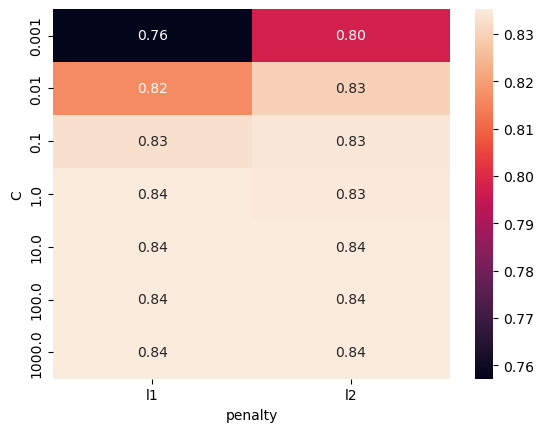

In [14]:
# See the results of different hyper parameters
results = pd.DataFrame( best_model.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we could use 1 - x
results['accuracy'] = best_model.cv_results_['mean_test_score']

# get rid of classifier__XX in columns
cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# lets show the results across penalty & C values
sns.heatmap( results.pivot('C','penalty','accuracy'),
             annot=True, fmt='3.2f')

training set accuracy (n=24420): 0.836
test set accuracy (n=8141): 0.840

classificiation report on test set performance
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6222
           1       0.70      0.56      0.62      1919

    accuracy                           0.84      8141
   macro avg       0.79      0.74      0.76      8141
weighted avg       0.83      0.84      0.83      8141




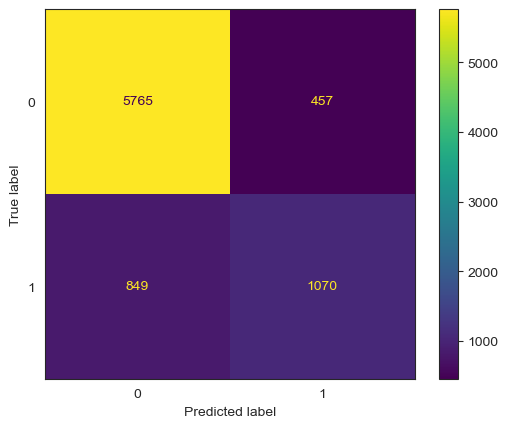

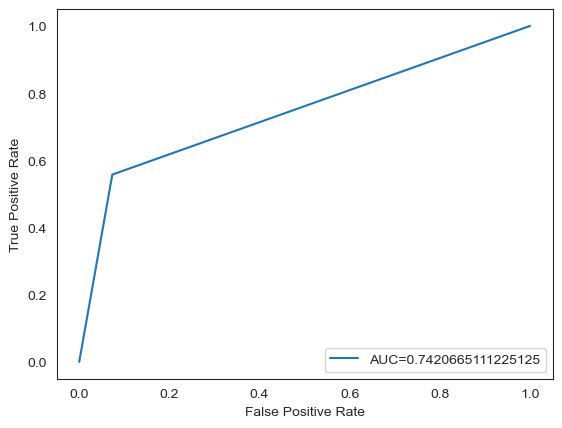

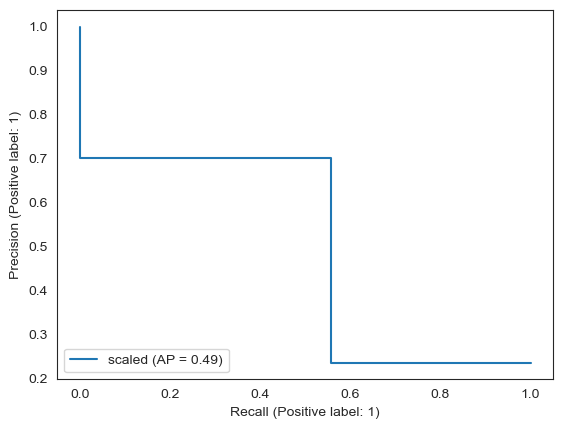

In [15]:
show_metrics(y_train, y_test, best_model.predict(X_train), best_model.predict(X_test), 'scaled')

### SVM Results

In [16]:
# Best model's parameters
best_model2.best_params_, best_model2.best_score_

({'classifier__C': 1.0, 'classifier__kernel': 'linear'}, 0.8312039312039312)

<AxesSubplot:xlabel='penalty', ylabel='C'>

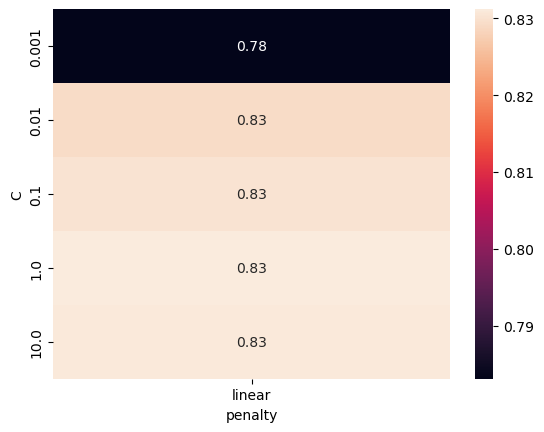

In [17]:
# See the results of different hyper parameters
results2 = pd.DataFrame( best_model2.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we could use 1 - x
results2['accuracy'] = best_model2.cv_results_['mean_test_score']

# get rid of classifier__XX in columns
cols2 = results2.columns.to_series().str.split('__').apply(lambda x: x[-1])
results2.columns = cols

# lets show the results across penalty & C values
sns.heatmap( results2.pivot('C','penalty','accuracy'),
             annot=True, fmt='3.2f')

training set accuracy (n=24420): 0.834
test set accuracy (n=8141): 0.837

classificiation report on test set performance
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      6222
           1       0.69      0.56      0.62      1919

    accuracy                           0.84      8141
   macro avg       0.78      0.74      0.76      8141
weighted avg       0.83      0.84      0.83      8141




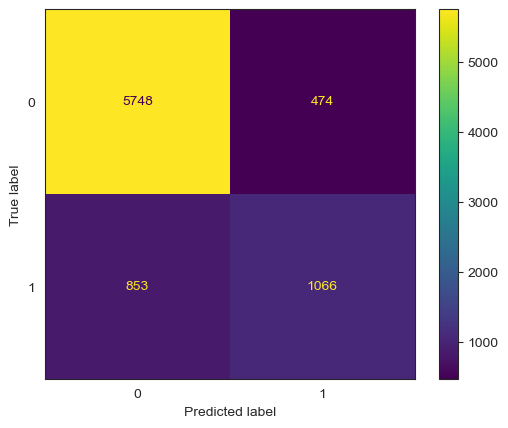

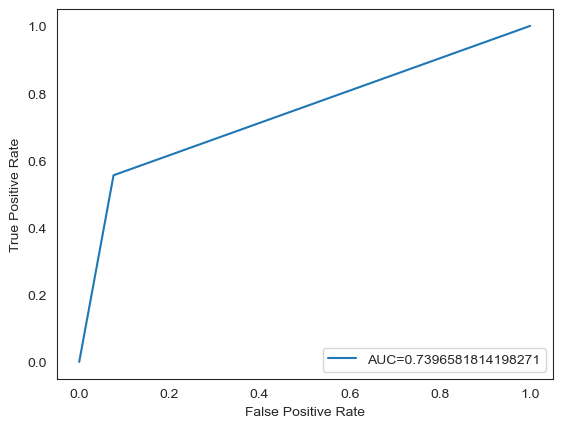

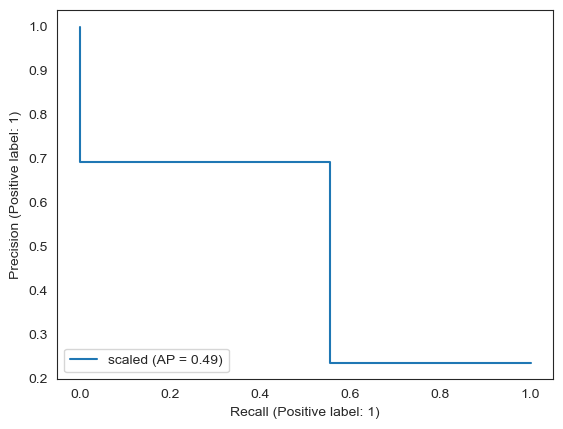

In [18]:
# Confusion matrix
show_metrics(y_train2, y_test2, best_model2.predict(X_train2), best_model2.predict(X_test2), 'scaled')

# Discussion

### Interpreting the result

In both the linear regression and SVM models, the precision/recall/f1 scores are great for <=\\$50k (around the 90\% range) and not as good for >\\$50k (55-70\%). This could be from the difference in support (<=\\$50k has 3x more datapoints), which could be causing the model to just predict <=\\$50k more often. The accuracy is relatively high at 84\%, which could be due to being able to predict <=\\$50k very well. Overall, this model makes accurate predictions when someone is making less than \\$50k.

### Limitations

The data we are using is from 1994, so the income numbers might not be entirely accurate due to gradual wage increases and inflation. The data is also strictly binary, so there is not a clear way to distinguish a \\$51k/year individual versus a \\$500k/year individual. Introducing a larger amount of >\\$50k data points could also change the way the models predict, as <=\\$50k makes up over 75\% of the data.

### Ethics & Privacy

The data is sourced from the 1994 Census database<a name="uci"></a>[<sup>[4]</sup>](#ucinote), so the participants consent to giving their information and the data anonymized. Further, the classification of >=50k and <50k does not expose information about what a participant's actual income is. There is potential for bias in this dataset, as certain areas of the US are known to be more/less wealthy, and there is no mention of where (besides it being in the US) the data is collected. Changing variables such as education level into one-hot encodings also removes the known underlying biases between higher education and income. With our study, we cannot determine an individual with our information so each individual person's private identity is safe.
### Conclusion

The project aims to predict whether individuals earn over or under \\$50,000 per year based on specific metrics, utilizing a Kaggle dataset that includes features like gender, race, and occupation. Through exploratory data analysis, we identified  potential biases and encoded non-numerical features. We built both a logistic regression model and SVM model to semi-accurately classify individuals' income levels, evaluating its performance based on accuracy and f1-score. These results show that we can predict if an individual can earn under 50k with relatively high accuracy but cannot predict over 50k with the same accuracy. Using this information, we can determine the income status of different zip codes across the US and identify if there are any trends in lower income areas. Using more recent data, we can see if past trends in these low income areas continue in being contributing factors in low income.

# Footnotes
<a name="importance-income"></a>1.[^](#incomeImportance): https://www.census.gov/content/dam/Census/library/working-papers/1997/adrm/sm97-05.pdf<br> 
<a name="health-income"></a>2.[^](#incomeHealth): https://equityhealthj.biomedcentral.com/articles/10.1186/s12939-019-0942-1<br>
<a name="mid-income"></a>3.[^](#midIncome): https://money.usnews.com/money/personal-finance/family-finance/articles/where-do-i-fall-in-the-american-economic-class-system<br>
<a name="ucinote"></a>4.[^](#uci): http://archive.ics.uci.edu/ml/datasets/Adult